In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from network.pspnet import PSPNet
%matplotlib inline
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# 初期設定
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [ ]:
from dataset import VOCDataset
from make_datapath_list import make_datapath_list
from data_transform import DataTransform

# 動作確認 ファイルパスのリストを取得
rootpath = "./data/VOCdevkit/VOC2012/"

train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath
)

print(train_img_list[0])
print(train_anno_list[0])

# 動作確認
# (RGB)の色の平均値と標準偏差
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

# データセット作成
train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# データの取り出し例
print(val_dataset.__getitem__(0)[0].shape)
print(val_dataset.__getitem__(0)[1].shape)
print(val_dataset.__getitem__(0))

In [ ]:
# 実行するたびに変わります

# 画像データの読み込み
index = 0
imges, anno_class_imges = train_dataset.__getitem__(index)

# 画像の表示
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# アノテーション画像の表示
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
p_palette = anno_class_img.getpalette()

anno_class_img_val = anno_class_imges.numpy()
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()

In [ ]:
# 画像データの読み込み
index = 0
imges, anno_class_imges = val_dataset.__getitem__(index)

# 画像の表示
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# アノテーション画像の表示
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
p_palette = anno_class_img.getpalette()

anno_class_img_val = anno_class_imges.numpy()
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()

In [ ]:
# モデルの定義
net = PSPNet(n_classes=21)
net
batch_size = 2
dummy_img = torch.rand(batch_size, 3, 475, 475)
out = net(dummy_img)
out

In [ ]:
from make_datapath_list import make_datapath_list
from dataset import VOCDataset
from torch.utils.data import DataLoader

# ファイルパスリスト作成
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

# Dataset作成
# (RGB)の色の平均値と標準偏差
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# DataLoader作成
batch_size = 8

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

In [ ]:
from network.pspnet import PSPNet

# ファインチューニングでPSPNetを作成
# ADE20Kデータセットの学習済みモデルを使用、ADE20Kはクラス数が150です
net = PSPNet(n_classes=150)

# ADE20K学習済みパラメータをロード
state_dict = torch.load("weights/pspnet50_ADE20K.pth")
net.load_state_dict(state_dict)

# 分類用の畳み込み層を、出力数21のものにつけかえる
n_classes = 21
net.decode_feature.classification = nn.Conv2d(
    in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

net.aux.classification = nn.Conv2d(
    in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

# 付け替えた畳み込み層を初期化する。活性化関数がシグモイド関数なのでXavierを使用する。


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:  # バイアス項がある場合
            nn.init.constant_(m.bias, 0.0)


net.decode_feature.classification.apply(weights_init)
net.aux.classification.apply(weights_init)


print('ネットワーク設定完了：学習済みの重みをロードしました')

In [ ]:
net

In [ ]:
from network.psploss import PSPLoss
criterion = PSPLoss(aux_weight=0.4)

In [ ]:
import torch.optim as optim
from network.lr_scheduler import lambda_epoch
from train import train_model

optimizer = optim.SGD([
    {
        "params": net.feature_conv.parameters(), "lr": 1e-3
    },
    {
        "params": net.feature_res_1.parameters(), "lr": 1e-3
    },
    {
        "params": net.feature_res_2.parameters(), "lr": 1e-3
    },
    {
        "params": net.feature_dilated_res_1.parameters(), "lr": 1e-3
    },
    {
        "params": net.feature_dilated_res_2.parameters(), "lr": 1e-3
    },
    {
        "params": net.pyramid_pooling.parameters(), "lr": 1e-3
    },
    {
        "params": net.decode_feature.parameters(), "lr": 1e-2
    },
    {
        "params": net.aux.parameters(), "lr": 1e-2
    },
], momentum=0.9, weight_decay=0.0001)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)
num_epochs = 30
train_model(
    net,
    dataloaders_dict,
    criterion,
    scheduler,
    optimizer,
    num_epochs
)

## Infer

### ファイルパスリストを用意

In [ ]:
# ファイルパスリスト作成
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

# 後ほどアノテーション画像のみを使用する

### ネットワークを用意

In [ ]:
from network.pspnet import PSPNet

net = PSPNet(n_classes=21)

# 学習済みパラメータをロード
state_dict = torch.load("./weights/pspnet50_30.pth",
                        map_location={'cuda:0': 'cpu'})
net.load_state_dict(state_dict)

print('ネットワーク設定完了：学習済みの重みをロードしました')

### 推論実行

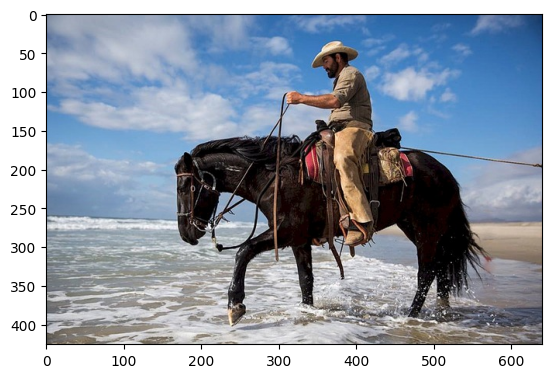

In [37]:
# 元画像の表示
image_file_path = "./data/cowboy-757575_640.jpg"
img = Image.open(image_file_path) # [高さ][幅][RGB]
img_width, img_height = img.size
plt.imshow(img)
plt.show()

In [38]:
# 前処理クラスの作成
color_mean = (0.485, 0.456, 0.406)
color_std = (0.225, 0.224, 0.225)
transform = DataTransform(
    input_size=475,
    color_mean=color_mean,
    color_std=color_std
)

In [39]:
# 前処理
## 適当なアノテーション画像を用意し、カラーパレットの情報を抜き出す
anno_file_path = val_anno_list[0]
anno_class_img = Image.open(anno_file_path) # [高さ][幅]
p_palette = anno_class_img.getpalette()
phase = "val"
img, anno_class_img = transform(phase, img, anno_class_img)

In [40]:
# PSPNetで推論
net.eval()
x = img.unsqueeze(0) # ミニバッチ化 ([1, 3, 475, 475])
outputs = net(x)
y = outputs[0]

/tmp/ipykernel_924520/3246214194.py:5: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)


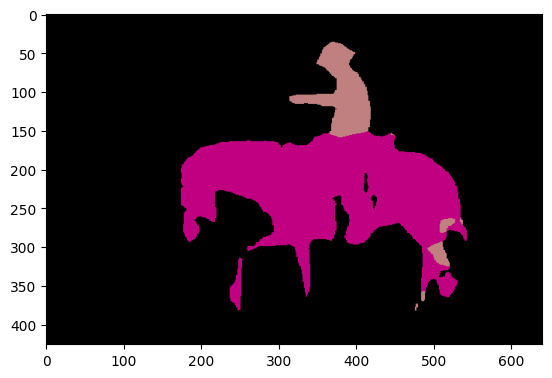

In [41]:
# PSPNetの出力から最大クラスを求め、カラーパレット形式にし、画像サイズを元に戻す
y = y[0].detach().numpy() # ミニバッチを外す
y = np.argmax(y, axis=0)
anno_class_img = Image.fromarray(np.uint8(y), mode="P")
anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
anno_class_img.putpalette(p_palette)
plt.imshow(anno_class_img)
plt.show()

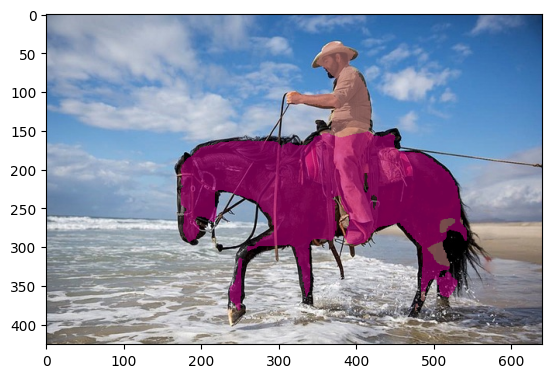

In [42]:
# 画像を浸透させて重ねる
trans_img = Image.new("RGBA", anno_class_img.size, (0, 0, 0, 0))
anno_class_img = anno_class_img.convert("RGBA")

for x in range(img_width):
    for y in range(img_height):
        pixel = anno_class_img.getpixel((x, y))
        r, g, b, a = pixel
        
        # RGBが全て0、つまり黒（Backgroundラベル）ならばスキップ
        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            continue
        trans_img.putpixel((x, y), (r, g, b, 150))
        # 150は透明度の大きさ（255で割られる）

img = Image.open(image_file_path)
result = Image.alpha_composite(img.convert("RGBA"), trans_img)
plt.imshow(result)
plt.show()